In [102]:
import numpy as np
import json
import csv

k = 4
X = np.genfromtxt('../data/impute_ordhinge_X_offset%d.csv' % k, delimiter=',').T
Y = np.genfromtxt('../data/impute_ordhinge_Y_offset%d_pre.csv' % k, delimiter=',')

entry_test_data = np.genfromtxt('../data/all_samples_filtered_entry_test.csv', delimiter=',')
instrument_test_data = np.genfromtxt('../data/all_samples_filtered_instrument_test.csv', delimiter=',')
train_data = np.genfromtxt('../data/all_samples_filtered_train.csv', delimiter=',')
m, n = train_data.shape
print(train_data.shape, entry_test_data.shape)

with open('../data/all_samples.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    key_to_index = dict([(h, i) for i, h in enumerate(header)])
    data_labels = list(reader)
    
def get_label(i, key):
    return data_labels[i][key_to_index[key]]
print(X.shape, Y.shape)
    
all_samples_filtered = np.genfromtxt('../data/all_samples_filtered_train.csv', delimiter=',')

with open('../data/all_samples_filtered.csv', 'r') as f:
    reader = csv.reader(f)
    features = next(reader)[1:]
    
print('Num features', len(features), features[:5])


(16291, 250) (16291, 250)
(16291, 4) (4, 250)
Num features 250 ['ADIR:Q11', 'ADIR:Q12', 'ADIR:Q13', 'ADIR:Q14', 'ADIR:Q15']


In [103]:
approx = X.dot(Y)

SRS:Q16
(16291, 250)
(16291, 250)
Train dist ['-1 (0.301496)', '1 (0.287886)', '2 (0.230137)', '3 (0.180481)']
[-1.0, 1.0, 2.0, 3.0]
Entry Test dist ['-1 (0.314815)', '1 (0.263889)', '2 (0.248843)', '3 (0.172454)']
Instrument Test dist ['1 (0.346008)', '2 (0.281369)', '3 (0.201521)', '-1 (0.171103)']


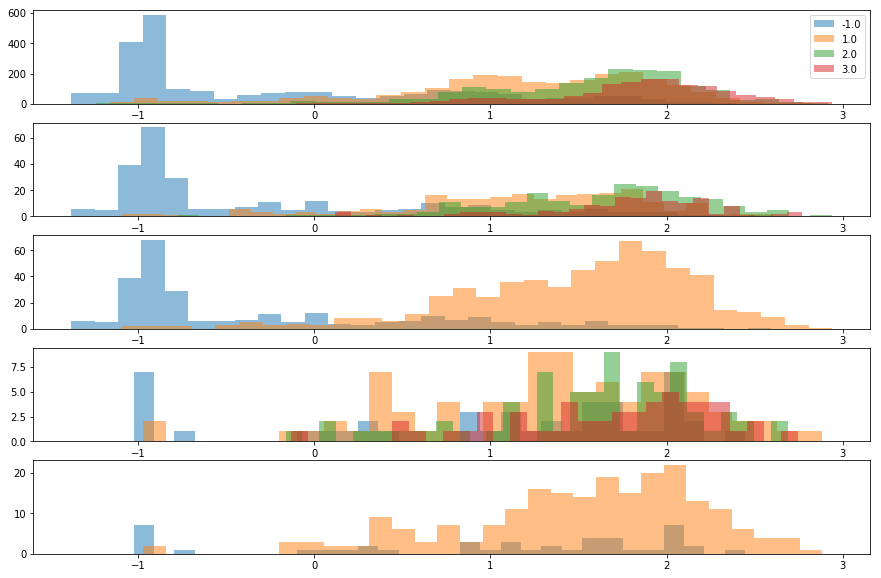

In [104]:
import matplotlib.pyplot as plt
from collections import Counter

#feature = 200
feature = 200

print(features[feature])
print(train_data.shape)
print(entry_test_data.shape)

c = Counter(train_data[:, feature][train_data[:, feature] != 0])
print('Train dist', ['%d (%f)' % (x[0], x[1]/sum([y for y in c.values()])) for x in c.most_common()])

options = sorted(c.keys())
print(options)

c = Counter(entry_test_data[:, feature][entry_test_data[:, feature] != 0])
print('Entry Test dist', ['%d (%f)' % (x[0], x[1]/sum([y for y in c.values()])) for x in c.most_common()])
c = Counter(instrument_test_data[:, feature][instrument_test_data[:, feature] != 0])
print('Instrument Test dist', ['%d (%f)' % (x[0], x[1]/sum([y for y in c.values()])) for x in c.most_common()])

plt.figure(figsize=(15,10))
ax1 = plt.subplot(5, 1, 1)
for i in options:
    plt.hist(approx[:, feature][train_data[:, feature]==i], 30, alpha=0.5, label=str(i))
plt.legend()

plt.subplot(5, 1, 2, sharex=ax1)
for i in options:
    plt.hist(approx[:, feature][entry_test_data[:, feature]==i], 30, alpha=0.5)

plt.subplot(5, 1, 3, sharex=ax1)
plt.hist(approx[:, feature][entry_test_data[:, feature]<0], 30, alpha=0.5)
plt.hist(approx[:, feature][entry_test_data[:, feature]>0], 30, alpha=0.5)

plt.subplot(5, 1, 4, sharex=ax1)
for i in options:
    plt.hist(approx[:, feature][instrument_test_data[:, feature]==i], 30, alpha=0.5)

plt.subplot(5, 1, 5, sharex=ax1)
plt.hist(approx[:, feature][instrument_test_data[:, feature]<0], 30, alpha=0.5)
plt.hist(approx[:, feature][instrument_test_data[:, feature]>0], 30, alpha=0.5)


#plt.xlim(-20, 20)
plt.show()

In [105]:
adir_indices = list(range(0, 139))
ados_indices = list(range(139, 185))
srs_indices = list(range(185, 249))

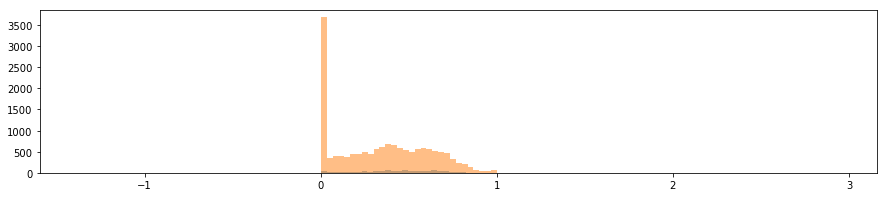

In [122]:
plt.figure(figsize=(15,3))
plt.subplot(1, 1, 1, sharex=ax1)
d = 'PDD-NOS'
diag_samples = [i for i in range(m) if data_labels[i][1] == d]
not_diag_samples = [i for i in range(m) if data_labels[i][1] != d]

plt.hist(X[diag_samples, 2], 30, alpha=0.5)
plt.hist(X[not_diag_samples, 2], 30, alpha=0.5)
#plt.hist(approx[missing_srs, feature][instrument_test_data[missing_srs, feature]!=0], 30, alpha=0.5)
#plt.hist(approx[list(set(range(m))-set(missing_srs)), feature], 30, alpha=0.5)

#plt.hist(approx[missing_srs, feature][instrument_test_data[missing_srs, feature]>0], 30, alpha=0.5)
plt.show()

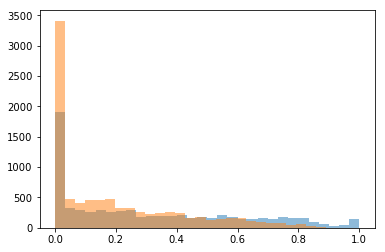

In [107]:
plt.hist(X[missing_srs, 0], 30, alpha=0.5)
plt.hist(X[list(set(range(m))-set(missing_srs)), 0], 30, alpha=0.5)
plt.show()

In [108]:
import json

# Round
imputed = approx.copy()
imputed[imputed < 0] = -1
imputed[imputed > 0] = np.round(imputed[imputed > 0])

m, n = imputed.shape
for i in range(n):
    max_value = np.amax(train_data[:, i])
    imputed[:, i] = np.minimum(imputed[:, i], max_value)

print(imputed)

[[-1.  0.  0. ...,  2.  0.  1.]
 [-1. -1. -1. ...,  2.  0.  1.]
 [-1. -1. -1. ...,  1.  2.  2.]
 ..., 
 [-1. -1. -1. ..., -1. -1.  0.]
 [-1. -1. -1. ..., -1.  1.  1.]
 [-1. -1. -1. ...,  0.  2.  1.]]


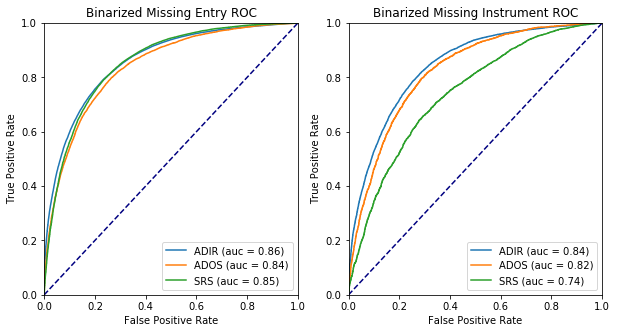

In [109]:
# roc curve
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
#fpr, tpr, _ = roc_curve(entry_test_data[entry_test_data != 0]>0, approx[entry_test_data != 0])
#roc_auc = auc(fpr, tpr)
#plt.plot(fpr, tpr, label='Binary Response (area = %0.2f)' % roc_auc)

fpr, tpr, _ = roc_curve(entry_test_data[:, adir_indices][entry_test_data[:, adir_indices] != 0]>0, approx[:, adir_indices][entry_test_data[:, adir_indices] != 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ADIR (auc = %0.2f)' % roc_auc)
fpr, tpr, _ = roc_curve(entry_test_data[:, ados_indices][entry_test_data[:, ados_indices] != 0]>0, approx[:, ados_indices][entry_test_data[:, ados_indices] != 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ADOS (auc = %0.2f)' % roc_auc)
fpr, tpr, _ = roc_curve(entry_test_data[:, srs_indices][entry_test_data[:, srs_indices] != 0]>0, approx[:, srs_indices][entry_test_data[:, srs_indices] != 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='SRS (auc = %0.2f)' % roc_auc)
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binarized Missing Entry ROC')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
#fpr, tpr, _ = roc_curve(instrument_test_data[instrument_test_data != 0]>0, approx[instrument_test_data != 0])
#roc_auc = auc(fpr, tpr)
#plt.plot(fpr, tpr, label='Binary Response (area = %0.2f)' % roc_auc)

fpr, tpr, _ = roc_curve(instrument_test_data[:, adir_indices][instrument_test_data[:, adir_indices] != 0]>0, approx[:, adir_indices][instrument_test_data[:, adir_indices] != 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ADIR (auc = %0.2f)' % roc_auc)
fpr, tpr, _ = roc_curve(instrument_test_data[:, ados_indices][instrument_test_data[:, ados_indices] != 0]>0, approx[:, ados_indices][instrument_test_data[:, ados_indices] != 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ADOS (auc = %0.2f)' % roc_auc)
fpr, tpr, _ = roc_curve(instrument_test_data[:, srs_indices][instrument_test_data[:, srs_indices] != 0]>0, approx[:, srs_indices][instrument_test_data[:, srs_indices] != 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='SRS (auc = %0.2f)' % roc_auc)
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binarized Missing Instrument ROC')
plt.legend(loc="lower right")

plt.show()

1.0 0.0 13513


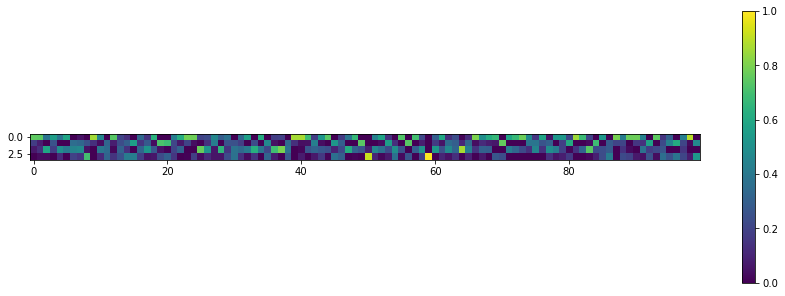

In [110]:
print(np.max(X), np.min(X), np.sum(X==0))
plt.figure(figsize=(15, 5))
cax = plt.imshow(X[:100, :].T)
plt.colorbar(cax)
plt.show()

4.95857800873 -3.29604849567 0


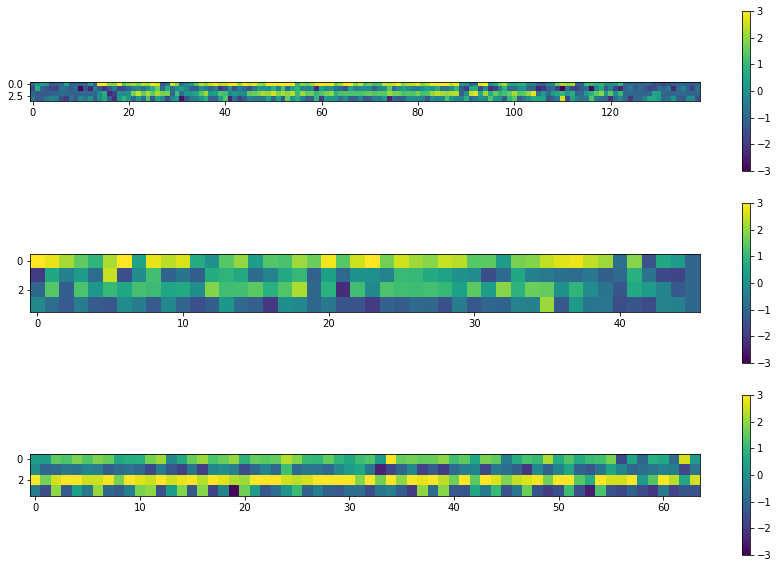

In [111]:
print(np.max(Y), np.min(Y), np.sum(Y==0))
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
cax = plt.imshow(Y[:, adir_indices])
plt.colorbar(cax)
plt.clim(-3, 3)
plt.subplot(3, 1, 2)
cax = plt.imshow(Y[:, ados_indices])
plt.colorbar(cax)
plt.clim(-3, 3)
plt.subplot(3, 1, 3)
cax = plt.imshow(Y[:, srs_indices])
plt.colorbar(cax)
plt.clim(-3, 3)
plt.show()

In [112]:
# Break down error by row and column
errors = np.abs(imputed[:, :250]-entry_test_data)
errors[entry_test_data==0] = 0

col_errors = np.sum(errors, axis=0)/np.sum(np.abs(entry_test_data), axis=0)
row_errors = np.sum(errors, axis=1)/np.sum(np.abs(entry_test_data), axis=1)

print(Counter(np.sum(np.abs(entry_test_data), axis=1)))

# If a row or column had no validation data, set its error to -1
col_errors[np.sum(np.abs(entry_test_data), axis=0)==0] = -1
row_errors[np.sum(np.abs(entry_test_data), axis=1)==0] = -1

Counter({6.0: 535, 3.0: 533, 9.0: 514, 5.0: 505, 4.0: 499, 7.0: 489, 8.0: 481, 14.0: 468, 12.0: 462, 22.0: 462, 2.0: 457, 15.0: 449, 13.0: 447, 19.0: 447, 10.0: 446, 11.0: 444, 16.0: 444, 17.0: 440, 18.0: 434, 20.0: 424, 21.0: 400, 23.0: 395, 24.0: 392, 25.0: 377, 26.0: 374, 1.0: 359, 29.0: 349, 0.0: 343, 30.0: 342, 28.0: 338, 27.0: 322, 31.0: 321, 33.0: 282, 32.0: 274, 35.0: 233, 34.0: 227, 36.0: 213, 37.0: 187, 38.0: 148, 40.0: 147, 39.0: 146, 41.0: 114, 42.0: 100, 43.0: 86, 44.0: 80, 46.0: 53, 45.0: 49, 48.0: 42, 49.0: 36, 47.0: 35, 51.0: 30, 53.0: 25, 50.0: 24, 52.0: 20, 55.0: 10, 56.0: 10, 54.0: 7, 62.0: 4, 57.0: 3, 59.0: 3, 58.0: 3, 60.0: 3, 63.0: 2, 64.0: 2, 65.0: 1})


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [113]:
# Plot error by missingness
col_missingness = np.sum(all_samples_filtered==0, axis=0)/m
row_missingness = np.sum(all_samples_filtered==0, axis=1)/n

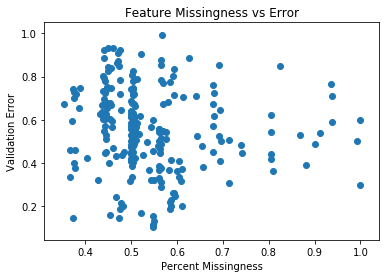

In [73]:
plt.scatter(col_missingness, col_errors)
plt.title('Feature Missingness vs Error')
plt.xlabel('Percent Missingness')
plt.ylabel('Validation Error')
plt.show()

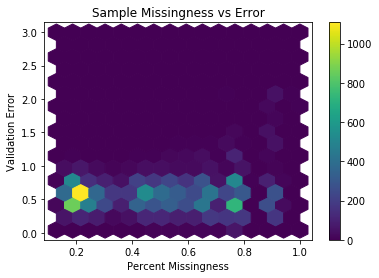

In [74]:
row_indices = [i for i in range(m) if row_errors[i] not in {-1, 1, 0}]
cay = plt.hexbin(row_missingness[row_indices], row_errors[row_indices], gridsize=15)
plt.colorbar(cay)
plt.title('Sample Missingness vs Error')
plt.xlabel('Percent Missingness')
plt.ylabel('Validation Error')
plt.show()

Female error rate 0.777575399172 Male error rate 0.795652925417


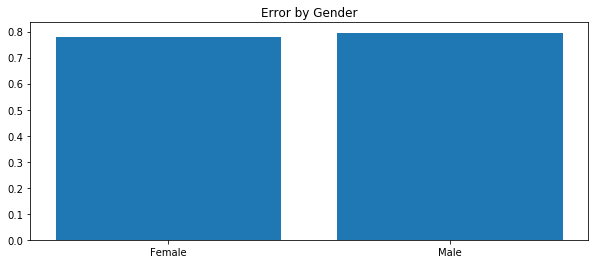

In [80]:
# Gender
female_indices = [i for i in range(m) if get_label(i, 'gender')=='Female']
male_indices = [i for i in range(m) if get_label(i, 'gender')=='Male']

female_errors = np.sum(errors[female_indices, :])/np.sum(entry_test_data[female_indices, :] != 0)
male_errors = np.sum(errors[male_indices, :])/np.sum(entry_test_data[male_indices, :] != 0)

print('Female error rate', female_errors, 'Male error rate', male_errors)

plt.figure(figsize=(10, 4))
plt.bar(range(2), [female_errors, male_errors])
plt.xticks(range(2), ['Female', 'Male'])
plt.title('Error by Gender')
plt.show()

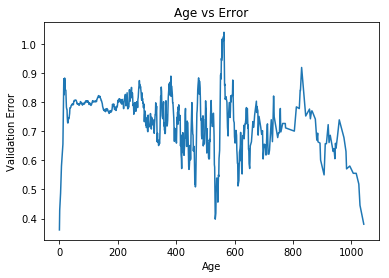

In [83]:
# Age
sample_ages = [None if get_label(i, 'age') == 'None' else int(get_label(i, 'age')) for i in range(m)]

ages = []
age_errors = []

for age in range(max([x for x in sample_ages if x is not None])):
    age_indices = [i for i in range(m) if sample_ages[i] == age]
    if np.sum(entry_test_data[age_indices, :] != 0) > 0:
        ages.append(age)
        age_errors.append(np.sum(errors[age_indices, :])/np.sum(entry_test_data[age_indices, :] != 0))
    
plt.plot(ages, np.convolve(age_errors, np.ones((12,))/12, mode='same'))
plt.title('Age vs Error')
plt.xlabel('Age')
plt.ylabel('Validation Error')
plt.show()

Counter({'National Database for Autism Research': 7231, 'AGRE': 4824, 'Simons Simplex Collection': 2872, 'Autism Consortium': 851, 'SVIP': 454, 'Cognoa': 59})


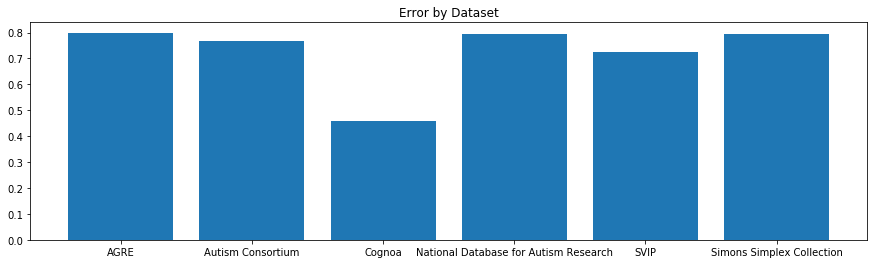

In [86]:
# Dataset
from collections import Counter

c = Counter([get_label(i, 'dataset') for i in range(m)])
print(c)

datasets = list(c.keys())
dataset_errors = []
for dataset in datasets:
    dataset_indices = [i for i in range(m) if get_label(i, 'dataset')==dataset]
    dataset_errors.append(np.sum(errors[dataset_indices, :])/np.sum(entry_test_data[dataset_indices, :] != 0))

plt.figure(figsize=(15, 4))
plt.bar(range(len(datasets)), dataset_errors)
plt.xticks(range(len(datasets)), datasets)
plt.title('Error by Dataset')
plt.show()

Counter({'Autism': 10478, 'None': 2709, 'Control': 1909, 'PDD-NOS': 841, 'Asperger': 354})


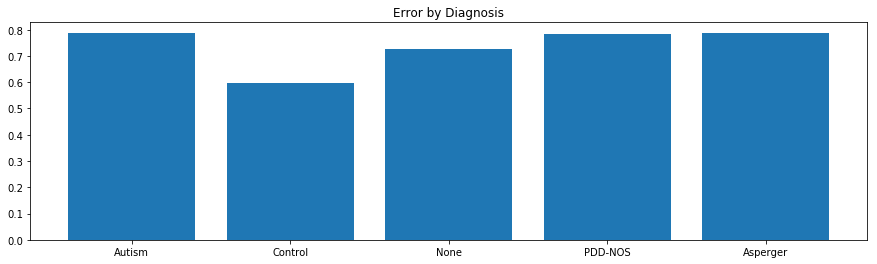

In [114]:
# Diagnosis
from collections import Counter

c = Counter([get_label(i, 'clinical_diagnosis') for i in range(m)])
print(c)

diagnoses = list(c.keys())
diagnosis_errors = []
for diagnosis in diagnoses:
    diagnosis_indices = [i for i in range(m) if get_label(i, 'clinical_diagnosis')==diagnosis]
    diagnosis_errors.append(np.sum(errors[diagnosis_indices, :])/np.sum(entry_test_data[diagnosis_indices, :] != 0))

plt.figure(figsize=(15, 4))
plt.bar(range(len(diagnoses)), diagnosis_errors)
plt.xticks(range(len(diagnoses)), diagnoses)
plt.title('Error by Diagnosis')
plt.show()

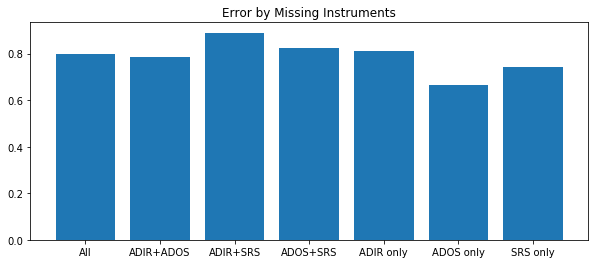

In [93]:
# Instrument
from collections import Counter

instruments = ['All', 'ADIR+ADOS', 'ADIR+SRS', 'ADOS+SRS', 'ADIR only', 'ADOS only', 'SRS only']
instrument_errors = []

adir_indices = set([i for i in range(m) if get_label(i, 'ADIR:diagnosis') != ''])
ados_indices = set([i for i in range(m) if get_label(i, 'ADOS:diagnosis') != ''])
srs_indices = set([i for i in range(m) if get_label(i, 'SRS:diagnosis') != ''])

instrument_errors.append(np.sum(errors[list(adir_indices & ados_indices & srs_indices), :])/np.sum(entry_test_data[list(adir_indices & ados_indices & srs_indices), :] != 0))
instrument_errors.append(np.sum(errors[list((adir_indices & ados_indices) - srs_indices), :])/np.sum(entry_test_data[list((adir_indices & ados_indices) - srs_indices), :] != 0))
instrument_errors.append(np.sum(errors[list((adir_indices & srs_indices) - ados_indices), :])/np.sum(entry_test_data[list((adir_indices & srs_indices) - ados_indices), :] != 0))
instrument_errors.append(np.sum(errors[list((ados_indices & srs_indices) - adir_indices), :])/np.sum(entry_test_data[list((ados_indices & srs_indices) - adir_indices), :] != 0))
instrument_errors.append(np.sum(errors[list(adir_indices - (ados_indices | srs_indices)), :])/np.sum(entry_test_data[list((adir_indices) - (ados_indices | srs_indices)), :] != 0))
instrument_errors.append(np.sum(errors[list(ados_indices - (adir_indices | srs_indices)), :])/np.sum(entry_test_data[list(ados_indices - (adir_indices | srs_indices)), :] != 0))
instrument_errors.append(np.sum(errors[list(srs_indices - (adir_indices | ados_indices)), :])/np.sum(entry_test_data[list(srs_indices - (adir_indices | ados_indices)), :] != 0))

plt.figure(figsize=(10, 4))
plt.bar(range(len(instruments)), instrument_errors)
plt.xticks(range(len(instruments)), instruments)
plt.title('Error by Missing Instruments')
plt.show()

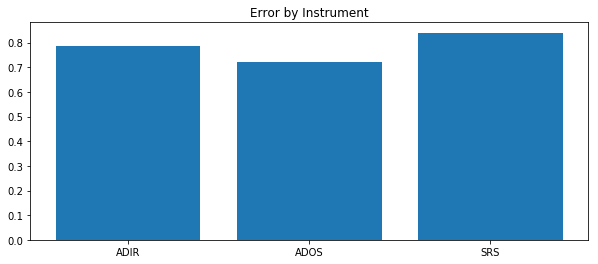

In [100]:
# Instrument
from collections import Counter

adir_indices = list(range(0, 139))
ados_indices = list(range(139, 185))
srs_indices = list(range(185, 249))

instruments = ['ADIR', 'ADOS', 'SRS']
instrument_errors = []
instrument_errors.append(np.sum(errors[:, adir_indices])/np.sum(entry_test_data[:, adir_indices] != 0))
instrument_errors.append(np.sum(errors[:, ados_indices])/np.sum(entry_test_data[:, ados_indices] != 0))
instrument_errors.append(np.sum(errors[:, srs_indices])/np.sum(entry_test_data[:, srs_indices] != 0))

plt.figure(figsize=(10, 4))
plt.bar(range(len(instruments)), instrument_errors)
plt.xticks(range(len(instruments)), instruments)
plt.title('Error by Instrument')
plt.show()